In [1]:
from IPython import get_ipython
my_variables = set(dir())  # Write this line at the beginning of cell
my_variables = list(set(dir()) - my_variables)  # Write these 2 lines at the end of cell
get_ipython().magic('%reset_selective -f [{}]'.format(','.join(my_variables)))
import cv2 as cv
import numpy as np
import numpy.ma as ma
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw 
import pylab

import math
import argparse

In [2]:
def plt_show(image, color = None):
    pic_size=5
    plt.figure(figsize = (pic_size, pic_size))
    plt.imshow(image, color)
    plt.show()

In [3]:
def otsu_loc(image_name):
    partsH = 4;  partsV = 1
    lim = [115, 106, 105, 90]
    
    ref = cv.imread(image_name, cv.IMREAD_GRAYSCALE)
    image = Image.open(image_name)
    new_pix = ImageDraw.Draw(image)  
    
    sizeV = image.size[1];  sizeH = image.size[0]

    stepV = np.array([x for x in range(0,sizeV-sizeV//partsH+1,int(sizeV//partsH))])  
    stepV=np.append(stepV,sizeV)
    
    stepH = np.array([x for x in range(0,sizeH-sizeH//partsV+1,int(sizeH//partsV))])    
    stepH=np.append(stepH, sizeH)
    index = 0
    pixarr = cv.imread(image_name, cv.IMREAD_GRAYSCALE)
    for i in range(len(stepV)-1):
        for j in range(len(stepH)-1):
            arr1 = arr = (pixarr[stepV[i]:stepV[i+1],stepH[j]:stepH[j+1]])
            limit = lim[index]
            index=index+1
            for x in range(stepV[i],stepV[i+1]):
                for y in range(stepH[j],stepH[j+1]):
                    if arr[x-stepV[i],y-stepH[j]] < limit:
                        pix = 0
                    else:
                        pix = 255
                    ref[x][y]=pix
                    new_pix.point((y, x), (pix, pix, pix)) 
    fig, ax = plt.subplots(1,2)
    plt.title("Local binarization Otsu's method")
    ax[0].imshow( Image.open(image_name) )
    ax[1].imshow(image)
    plt.show()
    return ref

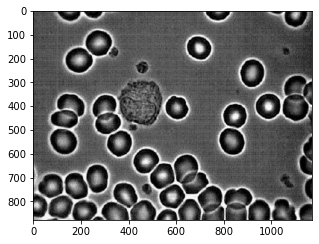

In [4]:
pic_size = 5
ref = cv.imread("pic1.jpg", cv.IMREAD_GRAYSCALE)
plt.figure(figsize = (pic_size, pic_size))
plt.imshow(ref, "gray")

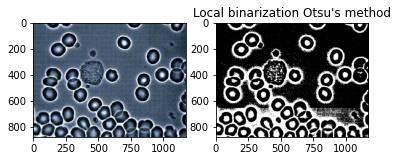

In [5]:
src = otsu_loc("pic1.jpg")

In [6]:
pows = 0.1

image_origin = cv.imread("pic1.jpg", 0)
image_shape = image_origin.shape
#бпф
fft = np.fft.fft2(image_origin)
spectr_shift = np.fft.fftshift(fft)

spectr_shift_normal = np.log(1+np.abs(spectr_shift))


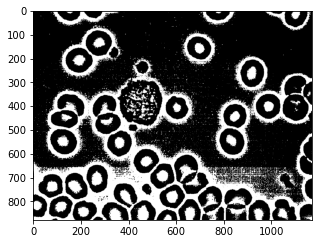

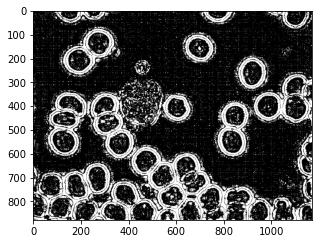

In [11]:
n=5
D_0 = 27
butter_filter_HF = np.zeros(image_shape)
for i in range(image_shape[0]):
    for j in range(image_shape[1]):
        D_u_v = math.sqrt((i - image_shape[0] / 2) ** 2 + (j - image_shape[1] / 2) ** 2)
        if D_u_v != 0: 
            butter_filter_HF[i, j] = 1 / (1 + (D_0 /D_u_v) ** (2 * n))

spectr_butter_filter_HF = butter_filter_HF * spectr_shift
spectr_butter_filter_HF_in_pow = np.abs(spectr_butter_filter_HF)**pows

result_butter_filter_HF = np.abs(np.fft.ifft2(spectr_butter_filter_HF))


_, result_butter_filter_HF = cv.threshold(result_butter_filter_HF,30,255,cv.THRESH_BINARY_INV)
cv.imwrite("result_butter_filter_HF.jpg", result_butter_filter_HF)


plt_show(src, "gray")


result_butter_filter_HF = cv.imread("result_butter_filter_HF.jpg",  cv.IMREAD_GRAYSCALE)


result_butter_filter_HF = ~result_butter_filter_HF
plt_show(result_butter_filter_HF, "gray")


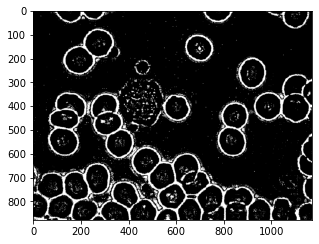

True

In [12]:
z = np.zeros((878,1172))
for i in range(len(result_butter_filter_HF)):
    for j in range(len(result_butter_filter_HF[0])):
        if ((result_butter_filter_HF[i][j]>115) & (src[i][j]>245)):
            z[i][j] = 255

plt_show(z, 'gray')
cv.imwrite("z1.jpg", z)

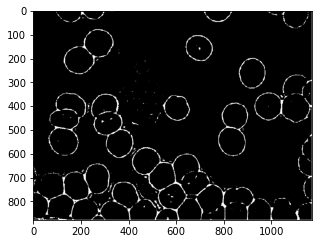

count =  42


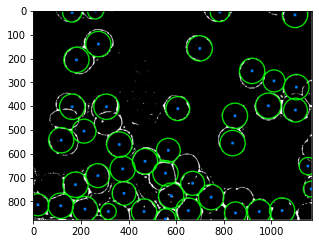

In [13]:
img = cv.imread("z1.jpg") 
circle = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5,4))
img = cv.erode(img, circle)

for i in range(image_shape[0]):
    for j in range(image_shape[1]):
        if(i==0)|(j==0)|(i==image_shape[0]-1)|(j==image_shape[1]-1):
            img[i][j]=255
plt_show(img)


blur_hor = cv.filter2D(img[:, :, 0], cv.CV_32F, kernel=np.ones((11,1,1), np.float32)/11.0, borderType=cv.BORDER_CONSTANT)
blur_vert = cv.filter2D(img[:, :, 0], cv.CV_32F, kernel=np.ones((1,11,1), np.float32)/11.0, borderType=cv.BORDER_CONSTANT)
mask = ((img[:,:,0]>blur_hor*1.2) | (img[:,:,0]>blur_vert*1.2)).astype(np.uint8)*255
# plt_show(mask)
len(mask)
circles = cv.HoughCircles(mask,
                           cv.HOUGH_GRADIENT,
                           minDist=95,
                           dp=3,
                           param1=150,
                           param2=50,
                           minRadius=30,
                           maxRadius=55)
output = img.copy()
c=0
# ensure at least some circles were found
if circles is not None:
    # convert the (x, y) coordinates and radius of the circles to integers
    circles = np.round(circles[0, :]).astype("int")
    # loop over the (x, y) coordinates and radius of the circles
    for (x, y, r) in circles:
        c = c+1
        # draw the circle in the output image, then draw a rectangle
        # corresponding to the center of the circle
        cv.circle(output, (x, y), r, (0, 255, 0), 4)
        cv.rectangle(output, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)
    # show the output image
   # cv.imshow("output", np.hstack([output]))
print("count = ", c) 
plt_show(output) 


[[[   1   -1   -1   -1]
  [   2    0   -1   -1]
  [   3    1   -1   -1]
  ...
  [2931 2929   -1   -1]
  [2932 2930   -1   -1]
  [  -1 2931   -1   -1]]]


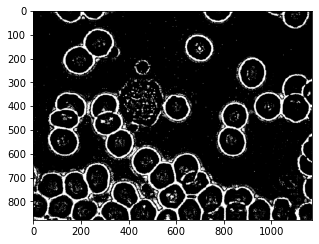

In [17]:
img = cv.imread("z1.jpg") 
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
c, binary = cv.threshold(gray,190,255,cv.THRESH_BINARY)


contours, hierarchy = cv.findContours(binary,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)
print(hierarchy)
contour=[]
for i in contours:
    if(20<len(i)<80):
        contour.append(i)
        
img[img >190]= 255
# cv.drawContours(img,contour,-1,(0,0,255),2)
 
plt_show(img)
# cv.waitKey(0)


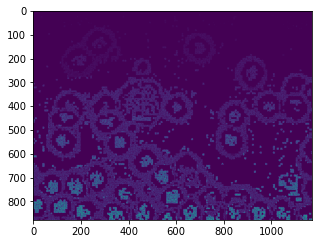

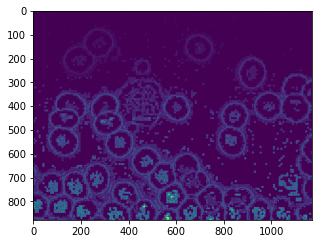

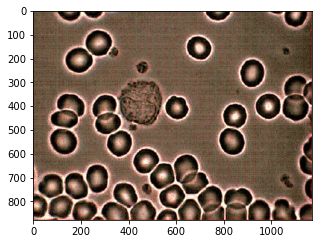

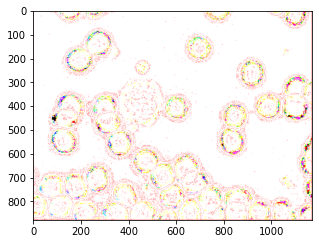

In [15]:
img = cv.imread("z1.jpg", cv.IMREAD_GRAYSCALE)

_, markers_for_bublick = cv.connectedComponents(img)


markers_for_bublick = markers_for_bublick + 1
markers_for_bublick[img==255] = 0


plt_show(markers_for_bublick)


reference = cv.imread("pic1.jpg")
markers_for_bublick = cv.watershed(reference, markers_for_bublick)


plt_show(markers_for_bublick)

reference[markers_for_bublick == -1] = [255, 0, 0]


plt_show(reference)


reference[reference>0]=255
reference[markers_for_bublick == -1] = [255, 0, 0]
plt_show(reference)